### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [91]:
#SETUP

import numpy as np
from matplotlib import pyplot as plt
#dont know which one of the two following I will need:
#from astroML.utils import split_samples
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#from astroML.classification import GMMBayes
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

sdss_color_data = np.load("/Users/katiebarnhart/Documents/hw8_data_1.npy")

In [51]:
# PART 1

#lets find things out about this data
#print(type(sdss_color_data)) 
print("The SDSS data looks like: ", np.shape(sdss_color_data))
print("The first element is ", sdss_color_data[0])
print("The second element is ", sdss_color_data[1])
#okay so this is 50000 data points, each point has 8 different characteristics
#print(sdss_color_data.ndim)
print("The names of all the columns are: ", sdss_color_data.dtype.names)

#what and where are the column names? 
#I dont know how to find the column names. I looked them up on the website
#A compilation of label info:
#the first 5 are colorband fluxes in some sort of units:
# 1st column = 'u'
# 2nd column = 'g'
# 3rd column = 'r'
# 4th column = 'i'
# 5th column = 'z'

#the sixth is the classification: is it a quasar or a galaxy
# 6th column = 'specClass'

#the seventh is the redshift
# 7th column = 'redshift'

#the eigth is errors on the redshift measurements
# 8th column = 'redshift_err'


#filterband differences 
ug = np.array(sdss_color_data['u'] - sdss_color_data['g'])
gr = np.array(sdss_color_data['g'] - sdss_color_data['r'])
ri = np.array(sdss_color_data['r'] - sdss_color_data['i'])
iz = np.array(sdss_color_data['i'] - sdss_color_data['z'])

classifications = sdss_color_data['specClass']

redshift = sdss_color_data['redshift']

galaxy_quantity = 0
quasar_quantity = 0
for i in classifications:
    if i == 'QSO':
        quasar_quantity += 1
    if i == 'GALAXY':
        galaxy_quantity += 1

print("galaxies: ", galaxy_quantity, "quasars: ", quasar_quantity)
#print(ug)

The SDSS data looks like:  (50000,)
The first element is  (19.46392, 18.89363, 18.85225, 18.8241, 18.53599, 'QSO', 2.312959, 0.00019252)
The second element is  (18.33262, 16.29118, 15.3018, 14.81997, 14.45467, 'GALAXY', 0.05187586, 1.396275e-05)
The names of all the columns are:  ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
galaxies:  42808 quasars:  7192


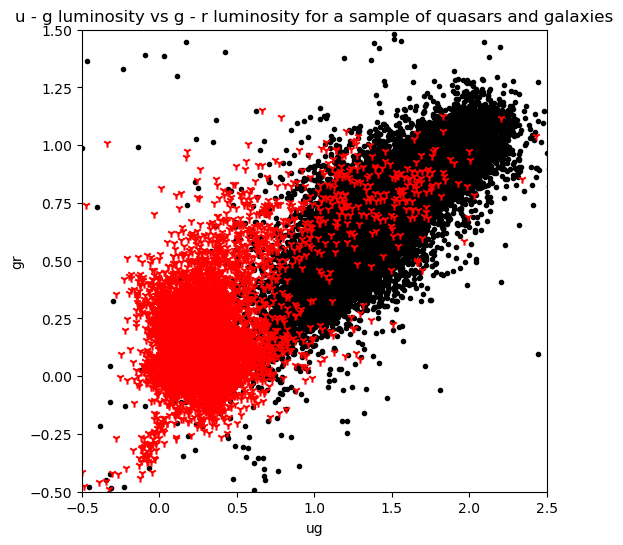

In [52]:
#PART 2

#stackin
part2_data_array = np.vstack((ug, gr, classifications))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

xlim = (-0.5, 2.5)
ylim = (-0.5, 1.5)

colormap_pt2 = ['red', 'black']
Galaxies = sdss_color_data['specClass'] == 'GALAXY'
Quasars = sdss_color_data['specClass'] == 'QSO'

ax.scatter(ug[Galaxies], gr[Galaxies], c=colormap_pt2[1], marker='.')
ax.scatter(ug[Quasars], gr[Quasars], c=colormap_pt2[0], marker='1') #quasars red

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('ug')
ax.set_ylabel('gr')
ax.set_title('u - g luminosity vs g - r luminosity for a sample of quasars and galaxies')

plt.show()

In [56]:
#PART 3

#part 3 data array
X = np.vstack((ug, gr, ri, iz, redshift)).T
print(np.shape(X))

#label array 
target_label_array = []
for i in classifications:
    if i == 'QSO':
        target_label_array = np.append(target_label_array, 1)
    if i == 'GALAXY':
        target_label_array = np.append(target_label_array, 0)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, target_label_array, test_size=0.2, random_state=42)

(50000, 5)


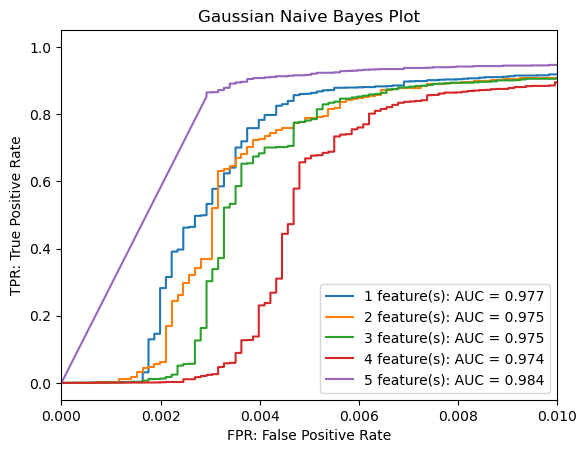

In [65]:
#PART 4

#Gaussian Naive Bayes
#Hindsight comment: changed the way I plot stuff here. Easier this way
xlim = (0, 0.01)

#predict_proba: "Return probability estimates for the test vector X"
for i in range(1, 6):
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i], y_train) #Thanks Kendra for debugging my slicing. It works now!
    y_pred_classify = gnb.predict_proba(X_test[:, :i])[:, gnb.classes_.tolist().index(1)]
    fpr, tpr, thresh = roc_curve(y_test, y_pred_classify) #roc_curve takes y_true and y_score
    roc_auc = auc(fpr, tpr) #false pos and true pos
    #roc_auc computes the area under the Receiver Operating Characteristic Curve, and returns Area Under Curve. does what it says on the tin
    plt.plot(fpr, tpr, label=f'{i} feature(s): AUC = {roc_auc:.3f}') #Kendra helped with this too, thank you. 
    #
    
#a guess for which feature makes classification trivially easy: redshift
plt.title("Gaussian Naive Bayes Plot")
plt.xlim(xlim)
plt.xlabel("FPR: False Positive Rate")
plt.ylabel("TPR: True Positive Rate")
plt.legend()
plt.show()

#Redshift!!

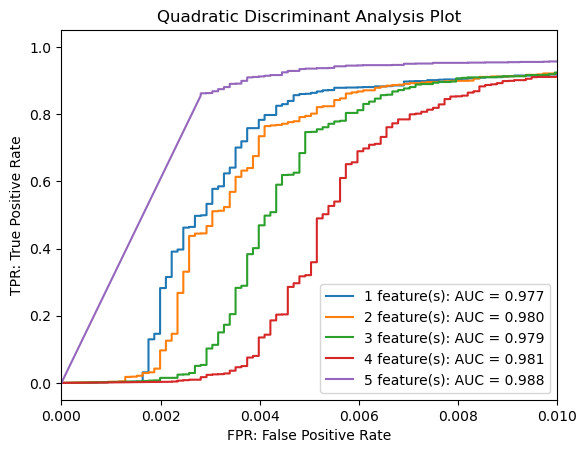

In [66]:
#PART 5

#Quadratic Discriminant Analysis

for i in range(1, 6):
    qda = QDA()
    qda.fit(X_train[:, :i], y_train)
    y_score_qda = qda.predict_proba(X_test[:, :i])[:, gnb.classes_.tolist().index(1)]
    fpr, tpr, thresh = roc_curve(y_test, y_score_qda) 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label=f'{i} feature(s): AUC = {roc_auc:.3f}') #the .(int)f controls how many sig figs

plt.title("Quadratic Discriminant Analysis Plot")
plt.xlim(xlim)
plt.xlabel("FPR: False Positive Rate")
plt.ylabel("TPR: True Positive Rate")
plt.legend()
plt.show()

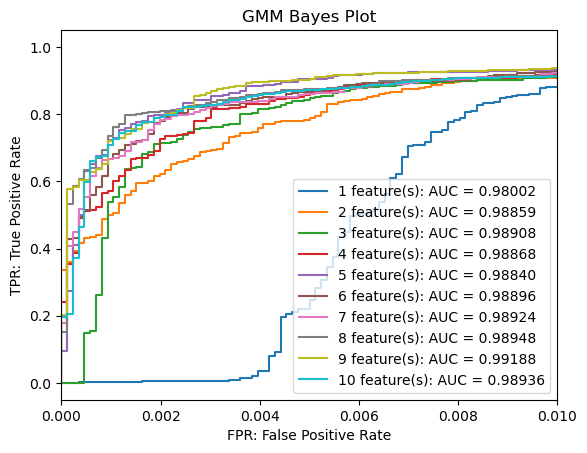

In [95]:
#PART 6

#GMM Bayes. 
#tried with AstroML first and it didnt work, probably was conflating something. Switched to scikit learn Gaussian Mixture

#JUST the color data!
X6 = np.vstack((ug, gr, ri, iz)).T
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, target_label_array, test_size=0.2, random_state=40)

for i in range(1, 11):
    #split
    gmmb_l2 = GaussianMixture(i, covariance_type='full')
    gmmb_l = GaussianMixture(i, covariance_type='full')
    gmmb_l2.fit(X_train6[y_train6==1])
    gmmb_l.fit(X_train6[y_train6==0])

    #gaussians need log likelihood
    lp_l = gmmb_l.score_samples(X_test6)
    lp_l2 = gmmb_l2.score_samples(X_test6)
    
    y_score_gmmb = lp_l2 - lp_l
    fpr, tpr, thresh = roc_curve(y_test6, y_score_gmmb) 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label=f'{i} feature(s): AUC = {roc_auc:.5f}') #needed more sigfigs


plt.title("GMM Bayes Plot")
plt.xlim(xlim)
plt.xlabel("FPR: False Positive Rate")
plt.ylabel("TPR: True Positive Rate")
plt.legend()
plt.show()

In [96]:
print("The best number of features is: ", 9)

The best number of features is:  9


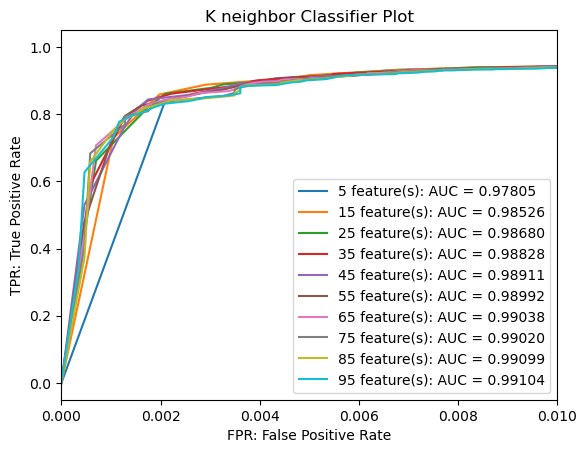

In [97]:
#PART 7

#KNN between 5 and 100, in steps of 10
#alot of this code is from lecture 19
for i in range(5, 101, 10):
    knc = KNeighborsClassifier(i)
    knc.fit(X_train6, y_train6)
    y_score_knc = knc.predict_proba(X_test6)[:, 1]

    fpr, tpr, thresh = roc_curve(y_test6, y_score_knc) 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label=f'{i} feature(s): AUC = {roc_auc:.5f}')

plt.title("K neighbor Classifier Plot")
plt.xlim(xlim)
plt.xlabel("FPR: False Positive Rate")
plt.ylabel("TPR: True Positive Rate")
plt.legend()
plt.show()

In [81]:
print("Best performance KNC: ", 95)

Best performance KNC:  95


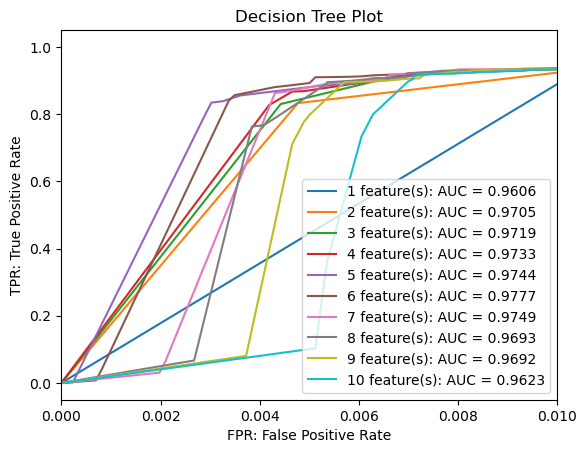

In [98]:
#PART 8

#decision tree: test depth from 1 to 10
#lecture 20

for i in range(1, 11):
    dtree = DecisionTreeClassifier(max_depth=i)
    dtree.fit(X_train6, y_train6)

    y_score_dtree = dtree.predict_proba(X_test6)[:, 1]

    fpr, tpr, thresh = roc_curve(y_test6, y_score_dtree) 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label=f'{i} feature(s): AUC = {roc_auc:.4f}')  

plt.title("Decision Tree Plot")
plt.xlim(xlim)
plt.xlabel("FPR: False Positive Rate")
plt.ylabel("TPR: True Positive Rate")
plt.legend()
plt.show()

In [85]:
print("Best Performance, decision tree: ", 6)

Best Performance, decision tree:  6


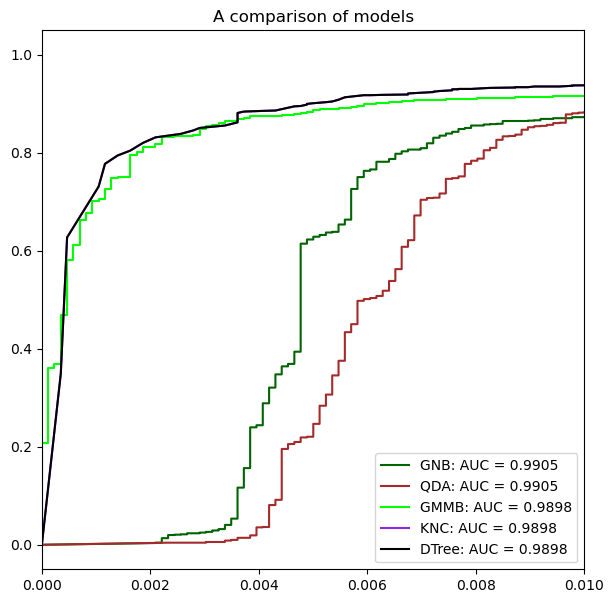

In [106]:
#PART 9

#its time for a heckton of ROC curve plots

fig = plt.figure(figsize=(7, 7))
#GNB
gnb9 = GaussianNB()
gnb9.fit(X_train6, y_train6)
y_score_gnb = gnb9.predict_proba(X_test6)[:, 1]
fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test6, y_score_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, color="darkgreen", label=f'GNB: AUC = {roc_auc:.4f}')

#QDA
qda9 = QDA()
qda9.fit(X_train6, y_train6)
y_score_qda = qda9.predict_proba(X_test6)[:, 1]
fpr_qda, tpr_qda, thresh_qda = roc_curve(y_test6, y_score_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)
plt.plot(fpr_qda, tpr_qda, color="brown", label=f'QDA: AUC = {roc_auc:.4f}')

#GMM Bayes, 9
gmmb9_1 = GaussianMixture(9)
gmmb9_2 = GaussianMixture(9)
gmmb9_1.fit(X_train6[y_train6==0])
gmmb9_2.fit(X_train6[y_train6==1])
lp_l1 = gmmb9_1.score_samples(X_test6)
lp_l2 = gmmb9_2.score_samples(X_test6)
y_score_gmmb = lp_l2 - lp_l
fpr_gmmb, tpr_gmmb, thresh_gmmb = roc_curve(y_test6, y_score_gmmb) 
roc_auc = auc(fpr_gmmb, tpr_gmmb)
plt.plot(fpr_gmmb, tpr_gmmb, color="lime", label=f'GMMB: AUC = {roc_auc:.4f}')

#KNC
knc9.fit(X_train6, y_train6)
y_score_knc = knc9.predict_proba(X_test6)[:, 1]
fpr_knc, tpr_knc, thresh_knc = roc_curve(y_test6, y_score_knc)
roc_auc_knc = auc(fpr_knc, tpr_knc)
plt.plot(fpr_knc, tpr_knc, color="blueviolet", label=f'KNC: AUC = {roc_auc:.4f}')

#dtree
dtree9 = DecisionTreeClassifier(max_depth=6)
dtree9.fit(X_train6, y_train6)
y_score_dtree = dtree9.predict_proba(X_test6)[:, 1]
fpr_dtree, tpr_dtree, thresh_dtree = roc_curve(y_test6, y_score_knc)
roc_auc_dtree = auc(fpr_dtree, tpr_dtree)
plt.plot(fpr_knc, tpr_knc, color="black", label=f'DTree: AUC = {roc_auc:.4f}')

plt.title("A comparison of models")
plt.xlim(xlim)
plt.legend()
plt.show()

Not immediately easy to tell which is best, maybe KNC

In [109]:
print(np.shape(X_train6))
print(X_train6[0])
print(X_train6[:, :1])

(40000, 4)
[1.18854 0.58573 0.40231 0.23174]
[[1.18854]
 [1.79584]
 [1.23424]
 ...
 [1.56945]
 [0.7572 ]
 [1.59838]]


ValueError: x and y must be the same size

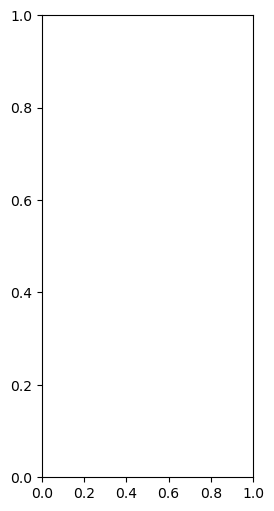

In [112]:
#PART 10

#print(np.shape(X_train6))
#print(X_train6[0])
#print(X_train6[:, :1])
pt_10_x = np.array(X_train6[:, :1])
pt_10_y = np.array(X_train6[:, :2])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(121)

color_code = np.array[]
for i in range(len(X_train6)):
    
#something has gone wrong here. 
"""for i in range(len(X_train6)): #hate having to do this the long way
    if y_train6[i]==1:
        ax.scatter(pt_10_x[i], pt_10_y[i], color="black", marker='.')
    else:
        ax.scatter(pt_10_x[i], pt_10_y[i], color="red", marker='1')

        """

<span style="color:red">NP: missing last part. -2pt</span>